In [1]:
import EoN
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])

from rDMP import SIS_DMP_based_pure_IC
from MMCA import SIS_MMCA_based_pure_IC
from ELE import SIS_ELE_based_pure_IC
from simulation_discrete import SIS_discrete_iter

# 实现SIS的 recurrent DMP (rDMP) 方法

For undirected graph $G=(V,E)$, rDMP holds $2|V||E|$ variables. Let $\gamma$ be the homogeneous recover rate and $\tau$ be the homogeneous transition rate, then we have:
$$
\frac{dI_i}{dt} = -\gamma I_i + \tau (1-I_i) \sum_{j\in \partial i} I_{j\rightarrow i}
$$
$$\frac{dI_{j\rightarrow i}}{dt} = -\gamma I_{j\rightarrow i} + \tau (1-I_j)\sum_{k\in \partial j \backslash i} I_{k\rightarrow j} $$
$$S_i = 1- I_i$$


# 实现SIS模型的MMCA方法

参考论文 Discrete-time Markov chain approach to contact-based disease spreading in complex networks， 实现简单图上的 MMCA：

$$
\begin{aligned}
p_{i}(t+1)=\left(1-q_{i}(t)\right)\left(1-p_{i}(t)\right)+(1-\gamma) p_{i}(t)
\end{aligned}
$$
where,
$$
q_{i}(t)=\prod_{j\in \partial i}\left(1-\tau p_{j}(t)\right)
$$
and $Ii(t) = p_{i}(t), S_{i}(t) = 1 - p_{i}(t)$

# 对 SIS 模型的 ELE 方法实现

参考论文： Abrupt phase transition of epidemic spreading in simplicial complexes
$$
P_{i}^{I}(t+1)=\left(1-P_{i}^{I}(t)\right)\left(1-q_{i}(t)\right)+P_{i}^{I}(t)(1-\mu)
$$
其中：
$$
q_{i}(t)=\prod_{j \in \partial_{i}}\left(1-\beta \frac{P_{i j}^{S I}(t)}{(1-P_{i}^{I}(t))}\right)
$$

$$
\begin{aligned}
P_{i j}^{S I}(t+1)=& P_{i j}^{S S}(t) \ q_{i j}(t) \left(1-q_{j i}(t) \right) + \\
&P_{i j}^{S I}(t) \ (1-\beta) q_{i j}(t) (1-\mu)+ \\
&P_{i j}^{I S}(t) \left(1 - (1-\beta) q_{j i}(t) \right) \mu+\\
&P_{i j}^{I I}(t)\mu (1-\mu)
\end{aligned}
$$

$$
\begin{aligned}
P_{i j}^{I S}(t+1)=& P_{i j}^{S S}(t) \ \left( 1 - q_{i j}(t) \right) q_{j i}(t) + \\
&P_{i j}^{S I}(t) \left(1 - (1 -\beta) q_{ij}(t) \right) \mu+ \\
&P_{i j}^{I S}(t) (1-\mu) \left((1-\beta) q_{j i}(t)\right)+\\
&P_{i j}^{I I}(t)(1-\mu) \mu 
\end{aligned}
$$

$$
\begin{aligned}
P_{i j}^{I I}(t+1)=& P_{i j}^{S S}(t)\left(1-q_{i j}(t) \right)\left(1-q_{j i}(t) \right) + \\
&P_{i j}^{S I}(t)\left(1-(1-\beta) q_{i j}(t) \right)(1-\mu)+ \\
&P_{i j}^{I S}(t)\left(1-(1-\beta) q_{j i}(t) \right)(1-\mu)+\\
&P_{i j}^{I I}(t)(1-\mu)^{2}
\end{aligned}
$$

$$
P_{ij}^{SS} = 1 - P_{ij}^{II}-P_{ij}^{IS}-P_{ij}^{SI}
$$

$$
q_{i j}(t)=\prod_{\substack{r \in \partial_{i} \\ r \neq j}}\left(1-\beta h_{ir}\right)
$$

$$
h_{ir} =  \frac{P_{i r}^{S I}(t)}{1-P_{i}^{I}(t)} \text{ or } 0
$$

# 不同方法的比较

In [2]:
def compare_methods(G, title):
    gamma = 0.05
    tau = 0.1

    tmin = 0
    tmax = 99
    tcount = 100
    N = G.order()
    report_times = np.linspace(tmin, tmax, tcount) #for simulations

    iterations = 1000

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,18))
    initial_infecteds = [np.random.choice(range(N))]
    
    print(initial_infecteds)
    
    obs_I = 0*report_times

    for counter in range(iterations):
        t, S, I = EoN.fast_SIS(G, tau, gamma, initial_infecteds = initial_infecteds, tmax = tmax)
        obs_I += EoN.subsample(report_times, t, I)
    SIMU = obs_I*1./(iterations*N)
    ax1.plot(report_times, SIMU, color="r", label="simulation-continue")
    
    rho = SIS_discrete_iter(iterations*10, pool_num=30, args=[G, tau, gamma, initial_infecteds, tmax])
    t = range(tmax+1)
    ax1.plot(t, rho, color = 'b', label="simulation-discrete")

    t, S, I = EoN.SIS_individual_based_pure_IC(G, tau, gamma, initial_infecteds, tmax=tmax, tcount = tcount)
    ax1.plot(t, I/N, "+", color = 'r', label="individual based", markerfacecolor="white")
    ax2.plot(t, I/N-SIMU, "+", color = 'r', label="individual based", markerfacecolor="white")
    ax3.plot(t, I/N-rho, "+", color = 'r', label="individual based", markerfacecolor="white")

    t, S, I = SIS_MMCA_based_pure_IC(G, tau, gamma, initial_infecteds, tmax=tmax+1, tcount = tcount)
    ax1.plot(t, I/N, "o", color = 'r', label="MMCA", markerfacecolor="white")
    ax2.plot(t, I/N-SIMU, "o", color = 'r', label="MMCA", markerfacecolor="white")
    ax3.plot(t, I/N-rho, "o", color = 'r', label="MMCA", markerfacecolor="white")


    t, S, I = SIS_DMP_based_pure_IC(G, tau, gamma, initial_infecteds, tmax=tmax, tcount = tcount)
    ax1.plot(t, I/N, "*", color = 'k', label="rDMP", markerfacecolor="white")
    ax2.plot(t, I/N-SIMU, "*", color = 'k', label="rDMP", markerfacecolor="white")
    ax3.plot(t, I/N-rho, "*", color = 'k', label="rDMP", markerfacecolor="white")

    t, S, I = EoN.SIS_pair_based_pure_IC(G, tau, gamma, initial_infecteds, tmax=tmax, tcount = tcount)
    ax1.plot(t, I/N, "x", color = 'b', label="pair based", markerfacecolor="white")
    ax2.plot(t, I/N-SIMU, "x", color = 'b', label="pair based", markerfacecolor="white")
    ax3.plot(t, I/N-rho, "x", color = 'b', label="pair based", markerfacecolor="white")
    
    t, S, I = SIS_ELE_based_pure_IC(G, tau, gamma, initial_infecteds, tmax=tmax+1, tcount = tcount)
    ax1.plot(t, I/N, "^", color = 'b', label="ELE based", markerfacecolor="white")
    ax2.plot(t, I/N-SIMU, "^", color = 'b', label="ELE based", markerfacecolor="white")
    ax3.plot(t, I/N-rho, "^", color = 'b', label="ELE based", markerfacecolor="white")

    ax2.plot(t, np.arange(len(t))*0, "-")
    ax3.plot(t, np.arange(len(t))*0, "-")

    ax1.set_xlabel('$t$')
    ax2.set_xlabel('$t$')
    ax1.set_ylabel('Prevalence')
    ax2.set_ylabel('L1-Error')
    ax1.legend()
    plt.suptitle(title)
    plt.show()

[42]


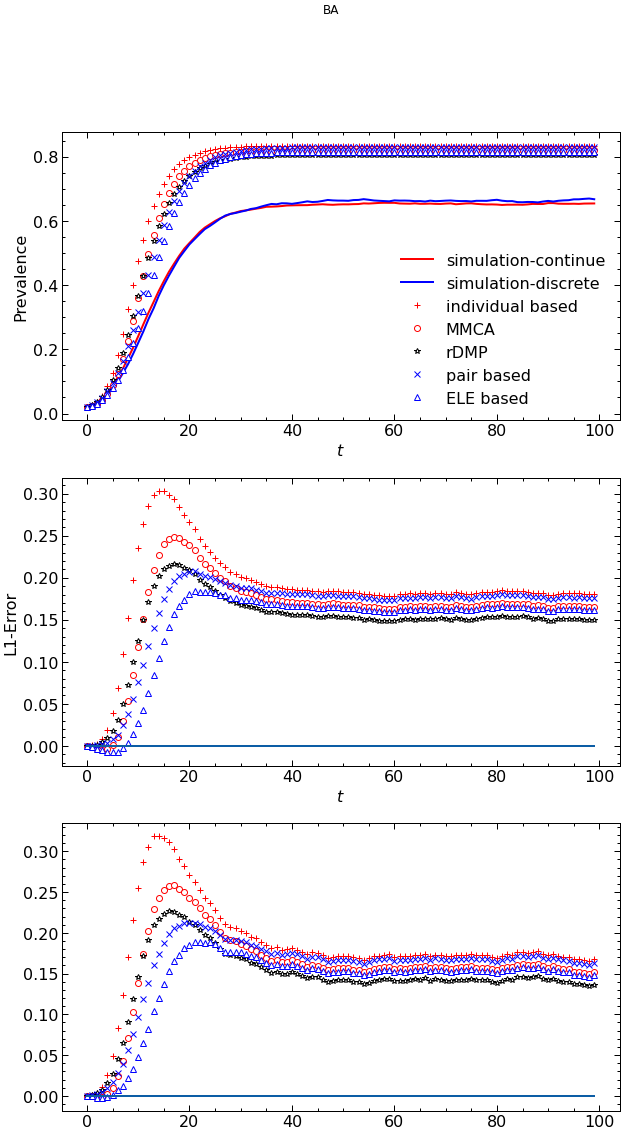

In [3]:
G = nx.barabasi_albert_graph(n=50, m=2)
title = "BA"
compare_methods(G, title)

[6]


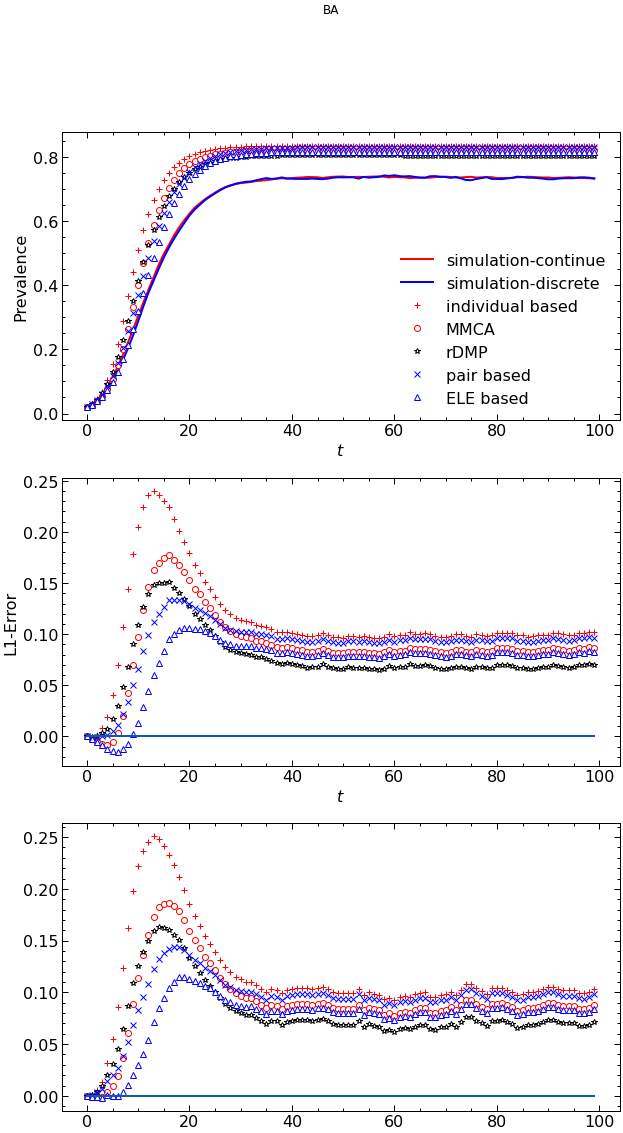

In [4]:
G = nx.barabasi_albert_graph(n=50, m=2)
title = "BA"
compare_methods(G, title)

[16]


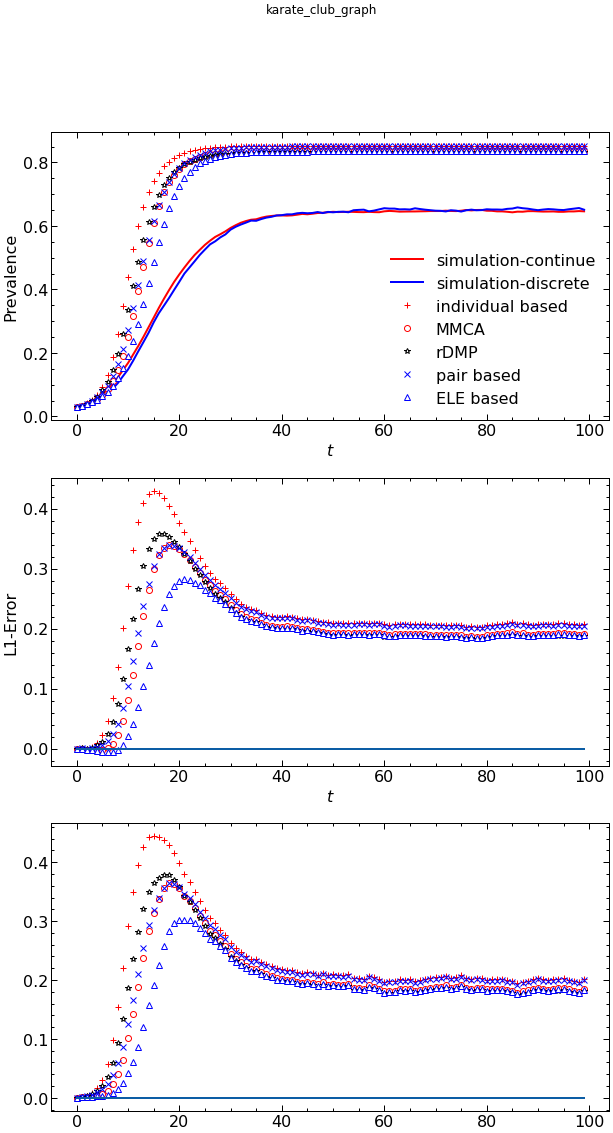

In [5]:
G = nx.karate_club_graph()
title = "karate_club_graph"
compare_methods(G, title)